### Setup Models

In [4]:
# LLM packages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# Agentic AI packages
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.document_loaders import PyPDFLoader

# LangGraph packges
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

import pandas as pd
import os
import functools
from typing import TypedDict, Annotated
import operator
from IPython.display import Image
import json
import uuid
from dotenv import load_dotenv
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')



In [2]:
# Start the LLM and embeddings
model = ChatOpenAI(
    model = "gpt-4o",
    openai_api_key = OPENAI_API_KEY
)

embedding = OpenAIEmbeddings(
    model = "text-embedding-3-large",
)

### Use Agents as Graph Nodes

#### Reuse the agents created in the previous notebooks by importing their notebooks

In [3]:
# Import QnA Agent
%run "PRODUCT-QnA-AGENTIC-CHATBOT.ipynb"
print("-----------------------------------")

# Import orders Agent
%run "ORDER-CHATBOT-GRAPH-AGENT.ipynb"




C:\Users\akash\AppData\Local\Temp\ipykernel_22744\4103377959.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(get_laptop_price("omega"))


2199
-1


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


[Document(metadata={'page': 0, 'source': '..//data//Laptop product descriptions.pdf'}, page_content='Fictional Laptop Descriptions\nAlphaBook Pro\nThe AlphaBook Pro is a sleek ultrabook with a 12th Gen Intel i7 processor, 16GB of DDR4 RAM,\nand a fast 1TB SSD. Ideal for professionals on the go, this laptop offers an impressive blend of\npower and portability.\nGammaAir X\nGammaAir X combines an AMD Ryzen 7 processor with 32GB of DDR4 memory and a 512GB\nNVMe SSD. Its thin and light form factor makes it perfect for users who need high performance in a\nportable design.\nSpectraBook S\nDesigned for power users, SpectraBook S features an Intel Core i9 processor, 64GB RAM, and a\nmassive 2TB SSD. This workstation-class laptop is perfect for intensive tasks like video editing and\n3D rendering.\nOmegaPro G17\nOmegaPro G17 is a gaming powerhouse with a Ryzen 9 5900HX CPU, 32GB RAM, and a 1TB\nSSD. Designed for gamers, it features a 17-inch display with a high refresh rate and powerful\ngraph

#### Build Helper Function to invoke an agent

In [5]:
def agent_node(state, agent, name, config):
    
    # extract thread-id from request for conversation memory
    thread_id = config["metadata"]["thread_id"]
    # Set up the config for calling the agent
    agent_config = {"configurable":{"thread_id": thread_id}}

    # Pass the thread-id to establish memory for chatbot
    # Invoke the agenrt with the state
    result = agent.invoke(state, agent_config)

    # Convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        final_result = AIMessage(result["messages"][-1].content)
    
    return {
        "messages": [final_result]
    }


#### Create the product QnA Node

- Note that since this agent is a create_react_agent only agent node will suffice as input

In [7]:
product_QnA_node = functools.partial(agent_node,
                                     agent = product_QnA_Agent,
                                     name = "Product_QnA_Agent"
                                     )

#### Create the Orders Agent Node

- Since this is a custom agent class, the entire graph needs to be provided as input

In [8]:
orders_node = functools.partial(agent_node,
                                agent = orders_agent.agent_graph,
                                name = "Orders_Agent")

### Create the Routing Agent and Chatbot

#### Create the Router Agent State

In [9]:
class RouterAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#### Create the Routing Agent

- Router Agent always differs from other types of agents. It does not have iterative loops but passess on the request to the destination nodes

In [14]:
class RouterAgent:
    def __init__(self, model, system_prompt, smalltalk_prompt, debug = False):
        self.system_prompt = system_prompt
        self.smalltalk_prompt = smalltalk_prompt
        self.model = model
        self.debug = debug

        # Initiate the Graph
        router_graph = StateGraph(RouterAgentState)

        # Add all the nodes
        router_graph.add_node("Router", self.call_llm)
        router_graph.add_node("Product_Agent", product_QnA_node)
        router_graph.add_node("Orders_Agent", orders_node)
        router_graph.add_node("Small_Talk", self.respond_smalltalk)

        # Add the conditional edge
        router_graph.add_conditional_edges(
            source="Router",
            path=self.find_route,
            path_map={
                "PRODUCT": "Product_Agent",
                "ORDER": "Orders_Agent",
                "SMALLTALK": "Small_Talk",
                "END": END
            }
        )

        # Add the node <-> node edges -One way routing from router (no coming back)
        router_graph.add_edge("Product_Agent", END)
        router_graph.add_edge("Orders_Agent", END)
        router_graph.add_edge("Small_Talk", END)

        # Set the entry point of the graph
        router_graph.set_entry_point("Router")
        
        # Compile the graph
        self.router_graph = router_graph.compile()

    
    def call_llm(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Call LLM received {messages}")
            
        #If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Call LLM result {result}")
        return { "messages":[result] }
    
    def respond_smalltalk(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Small talk received: {messages}")
            
        #If system prompt exists, add to messages in the front
        
        messages = [SystemMessage(content=self.smalltalk_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Small talk result {result}")
        return { "messages":[result] }
    
    def find_route(self, state: RouterAgentState):
        last_message = state["messages"][-1]

        if self.debug:
            print("Router: Last result from LLM:", last_message)
        
        destination = last_message.content

        if self.debug:
            print("Destination Chosen: {destination}")
        
        return destination




        



#### Create prompts

In [15]:
#Setup the system problem
system_prompt = """ 
You are a Router, that analyzes the input query and chooses 4 options:
SMALLTALK: If the user input is small talk, like greetings and good byes.
PRODUCT: If the query is a product question about laptops, like features, specifications and pricing.
ORDER: If the query is about orders for laptops, like order status, order details or update order quantity
END: Default, when its neither PRODUCT or ORDER.

The output should only be just one word out of the possible 4 : SMALLTALK, PRODUCT, ORDER, END.
"""

smalltalk_prompt="""
If the user request is small talk, like greetings and goodbyes, respond professionally.
Mention that you will be able to answer questions about laptop product features and provide order status and updates.
"""

#### Instantiate the Router Agent

In [16]:
router_agent = RouterAgent(model, 
                           system_prompt, 
                           smalltalk_prompt,
                           debug=False)

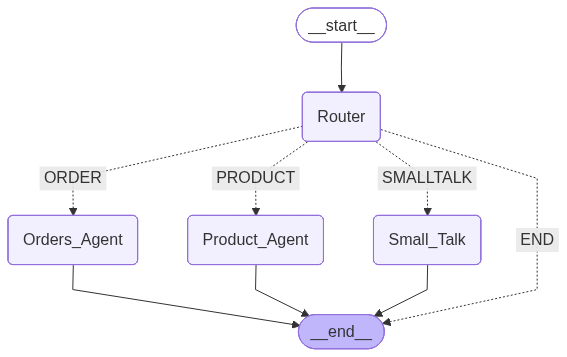

In [17]:
Image(router_agent.router_graph.get_graph().draw_mermaid_png())

### Execute the Routing Chatbot

In [18]:
#Execute a single request
messages=[HumanMessage(content="Tell me about the features of SpectraBook")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

================================ Human Message =================================

Tell me about the features of SpectraBook
================================== Ai Message ==================================

PRODUCT
================================== Ai Message ==================================

The SpectraBook S is designed for power users and comes with the following features:

- **Processor**: Intel Core i9
- **Memory**: 64GB RAM
- **Storage**: 2TB SSD

This workstation-class laptop is ideal for intensive tasks such as video editing and 3D rendering.


In [19]:
#Execute a single request
messages=[HumanMessage(content="What is the status of order ORD-7311?")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

================================ Human Message =================================

What is the status of order ORD-7311?
================================== Ai Message ==================================

ORDER
================================== Ai Message ==================================

The status of order ID **ORD-7311** is as follows:

- **Product Ordered:** NanoEdge Flex
- **Quantity Ordered:** 3
- **Delivery Date:** 2024-10-19

If you have any more questions or need further assistance, feel free to ask!


In [20]:
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-7311",
    "Can you add one more of that laptop to the order? ",
    "Tell me about the features of SpectraBook laptop",
    "How much does it cost?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = router_agent.router_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : How are you doing?

AGENT : Hello! I'm here to assist you with any questions about laptop product features or to provide updates on your order status. How can I help you today?
----------------------------------------
USER : Please show me the details of the order ORD-7311

AGENT : Here are the details for order **ORD-7311**:
- **Product Ordered**: NanoEdge Flex
- **Quantity Ordered**: 3
- **Delivery Date**: 2024-10-19

If you need any further assistance, feel free to ask!
----------------------------------------
USER : Can you add one more of that laptop to the order? 

AGENT : The quantity for order **ORD-7311** has been successfully updated to 4 units of the NanoEdge Flex laptop. If there's anything else you need, please let me know!
----------------------------------------
USER : Tell me about the features of SpectraBook laptop

AGENT : The SpectraBook S is designed for power users and offers the following features:

- **Processor**: 